## Introduction



This tutorial shows the spectra generation for spin 0 and 2 fields. We will only use the `CAR`
pixellisation to pass through the different steps of generation. If you are interested on doing the
same thing with `HEALPIX` pixellisation, you can have a look to the file
`tutorial_spectra_car_healpix.ipynb`.

The `CAR` survey mask is defined with `ra0, ra1, dec0, dec1` with 1 arcminute resolution. We simulate 2
splits with 20 µK.arcmin noise and we also include a point source mask with 100 holes of size 10
arcminutes. We appodize the survey mask with an apodisation of 1 degree and the point source mask
with an apodisation of 0.3 degree. We finally compute the spectra between the 2 splits of data up to
`lmax=1000`.



## Preamble



`matplotlib` magic



In [1]:
%matplotlib inline

Versions used for this tutorial



In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pspy, pixell
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("    pixell :", pixell.__version__)
print("      pspy :", pspy.__version__)

     Numpy : 1.18.0
Matplotlib : 3.1.2
    pixell : 0.6.0+34.g23be32d
      pspy : 0+untagged.88.g1ef44db


Get default data dir from `pspy` and set Planck colormap as default



In [3]:
from pspy.so_config import DEFAULT_DATA_DIR
pixell.colorize.mpl_setdefault("planck")

## Generation of the templates, mask and apodisation type



We start by specifying the `CAR` survey parameters, it will go from right ascension `ra0` to `ra1` and
from declination `dec0` to `dec1` (all in degrees) with a resolution of 1 arcminute.



In [4]:
ra0, ra1, dec0, dec1 = -25, 25, -25, 25
res = 1

For this example, we will make use of 3 components : Temperature (spin 0) and polarisation Q and U
(spin 2)



In [5]:
ncomp = 3

Given the parameters, we can generate the `CAR` template as follow



In [6]:
from pspy import so_map
template_car = so_map.car_template(ncomp, ra0, ra1, dec0, dec1, res)

We also define the binary template for the window function pixels: we set pixels inside the survey
at 1 and at the border to be zero



In [7]:
binary_car = so_map.car_template(1, ra0, ra1, dec0, dec1, res)
binary_car.data[:] = 0
binary_car.data[1:-1, 1:-1] = 1

## Generation of spectra



### Generation of simulations



We first have to compute $C_\ell$ data using a cosmology code such as [CAMB](https://camb.readthedocs.io/en/latest/) and we need to install it
since this is a prerequisite of `pspy`. We can do it within this notebook by executing the following
command



In [8]:
%pip install camb

Note: you may need to restart the kernel to use updated packages.


To make sure everything goes well, we can import `CAMB` and check its version



In [9]:
import camb
print("CAMB version:", camb.__version__)

CAMB version: 1.1.0


Now that `CAMB` is properly installed, we will produce $C_\ell$ data from $\ell$<sub>min</sub>=2 to
$\ell$<sub>max</sub>=10<sup>4</sup> for the following set of $\Lambda$CDM parameters



In [10]:
lmin, lmax = 2, 10**4
l = np.arange(lmin, lmax)
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10*np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

We finally have to write $C_\ell$ into a file to feed the `so_map.synfast` function for both
pixellisation templates



In [11]:
import os
output_dir = "/tmp/tutorial_spectra_spin0and2"
os.makedirs(output_dir, exist_ok=True)
cl_file = output_dir + "/cl_camb.dat"
np.savetxt(cl_file,
           np.hstack([l[:, np.newaxis], powers["total"][lmin:lmax]]))

Given the `CAMB` file, we generate a CMB realisation



In [12]:
cmb = template_car.synfast(cl_file)

Then, we make 2 splits out of it, each with 20 µK.arcmin rms in temperature and 20xsqrt(2) µK.arcmin
in polarisation



In [13]:
nsplits = 2
splits = [cmb.copy() for i in range(nsplits)]
for i in range(nsplits):
    noise = so_map.white_noise(cmb, rms_uKarcmin_T=20, rms_uKarcmin_pol=np.sqrt(2)*20)
    splits[i].data += noise.data

We can plot each component T, Q, U for both splits and for the original CMB realisation. We scale
the color map



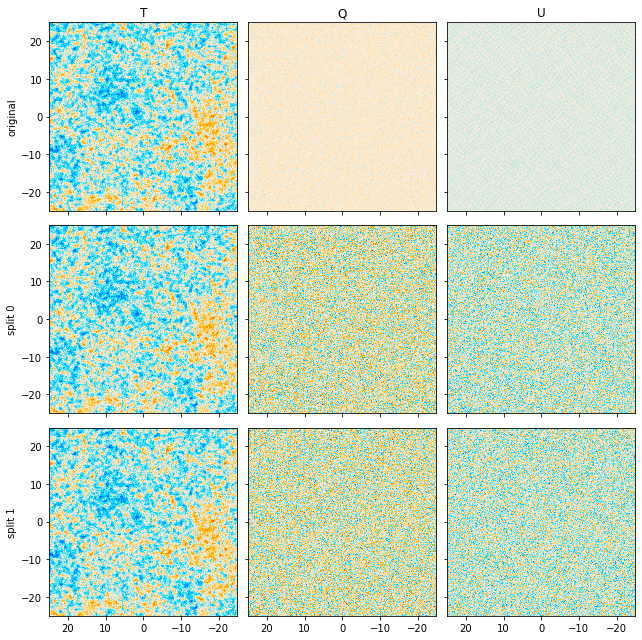

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
fields = ["T", "Q", "U"]
kwargs = dict(extent=[ra1, ra0, dec0, dec1], origin="lower")
for i, field in enumerate(fields):
    axes[0, i].set_title(fields[i])
    vrange = {"vmin": np.min([cmb.data[i], splits[0].data[i], splits[1].data[i]]),
              "vmax": np.max([cmb.data[i], splits[0].data[i], splits[1].data[i]])}
    axes[0, i].imshow(cmb.data[i], **kwargs, **vrange)
    axes[1, i].imshow(splits[0].data[i], **kwargs, **vrange)
    axes[2, i].imshow(splits[1].data[i], **kwargs, **vrange)

axes[0, 0].set_ylabel("original")
axes[1, 0].set_ylabel("split 0")
axes[2, 0].set_ylabel("split 1")
plt.tight_layout()

### Generate window



We then apodize the survey mask with a "Rectangle" pattern designed for rectangle maps and with 1
degree beam



In [15]:
from pspy import so_window
window = so_window.create_apodization(binary_car, apo_type="Rectangle", apo_radius_degree=1)

We also create a point source mask made of 100 holes each with a 10 arcminutes size



In [16]:
mask = so_map.simulate_source_mask(binary_car, n_holes=100, hole_radius_arcmin=10)

and we apodize it



In [17]:
mask = so_window.create_apodization(mask, apo_type="C1", apo_radius_degree=0.3)

The window is given by the product of the survey window and the mask window



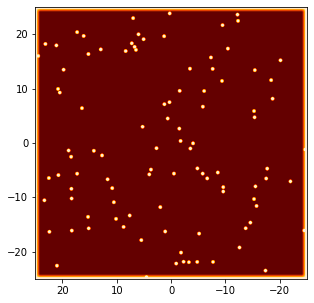

In [18]:
window.data *= mask.data
plt.figure(figsize=(5, 5))
plt.imshow(window.data, **kwargs, vmin=-1, vmax=+1)

### Compute mode coupling matrix



For spin 0 and 2 the window need to be a tuple made of two objects: the window used for spin 0 and the
one used for spin 2



In [19]:
window = (window, window)

The windows (for `spin0` and `spin2`) are going to couple mode together, we compute a mode coupling
matrix in order to undo this effect given a binning file (format: lmin, lmax, lmean) and a
$\ell$<sub>max</sub> value of 1000



In [20]:
lmax = 1000
binning_file = "/tmp/tutorial_spectra_spin0and2/binning.dat"
from pspy import pspy_utils
pspy_utils.create_binning_file(bin_size=40, n_bins=100, file_name=binning_file)
from pspy import so_mcm
mbb_inv, Bbl = so_mcm.mcm_and_bbl_spin0and2(window, binning_file, lmax=lmax, type="Dl", niter=0)

### Compute alms and bin spectra



In [21]:
from pspy import sph_tools
alms = [sph_tools.get_alms(split, window, niter=0, lmax=lmax) for split in splits]

We need to specify the order of the spectra to be used by `pspy`



In [22]:
spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]

and we finally build a dictionary of cross split spectra



In [23]:
Db_dict = {}
from itertools import combinations_with_replacement as cwr
for (i1, alm1), (i2, alm2) in cwr(enumerate(alms), 2):
  from pspy import so_spectra
  l, ps = so_spectra.get_spectra(alm1, alm2, spectra=spectra)
  lb, Db = so_spectra.bin_spectra(l,
                                  ps,
                                  binning_file,
                                  lmax,
                                  type="Dl",
                                  mbb_inv=mbb_inv,
                                  spectra=spectra)
  Db_dict.update({"split{}xsplit{}".format(i1, i2): Db})

To compare with the input $C_\ell$, we also compute the theory spectra and binned spectra



In [24]:
from pspy import pspy_utils
l, ps_theory = pspy_utils.ps_lensed_theory_to_dict(cl_file, 'Dl', lmax=lmax)
ps_theory_b = so_mcm.apply_Bbl(Bbl, ps_theory, spectra=spectra)

and we finally plot all the results



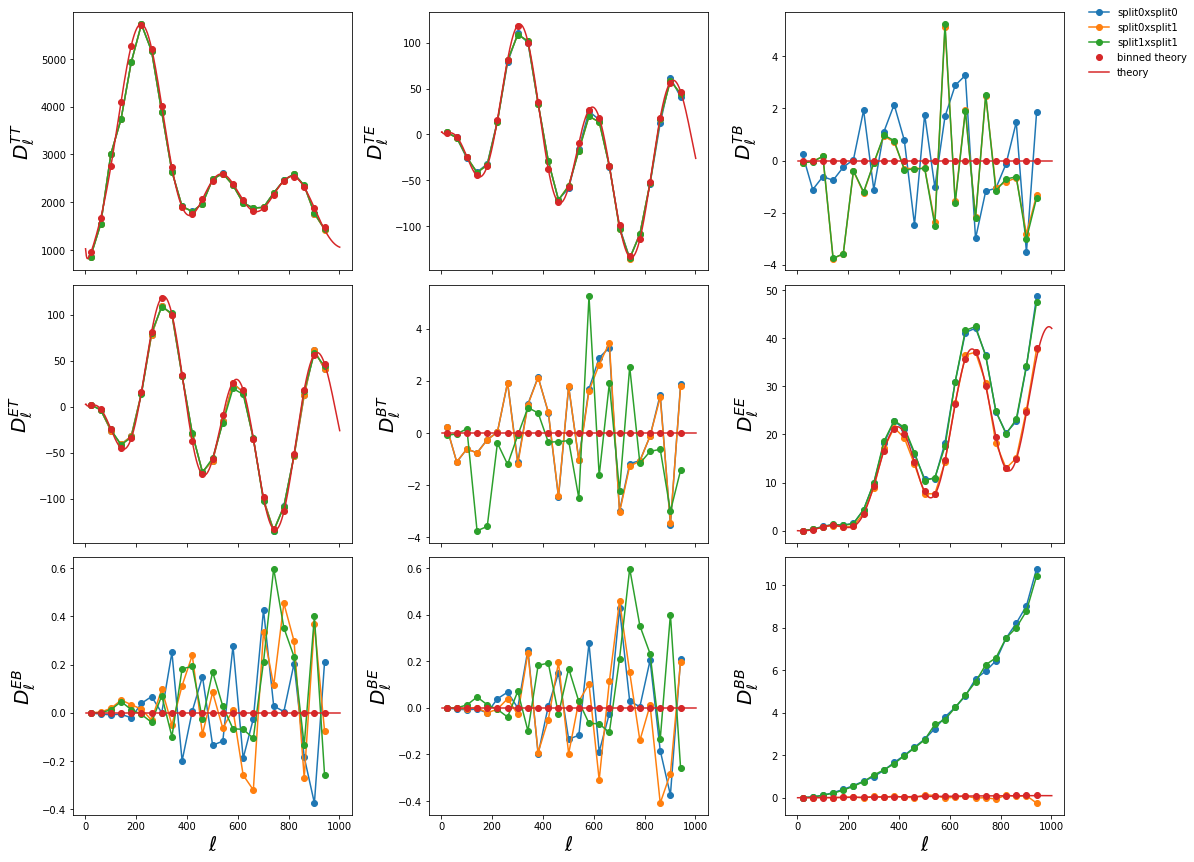

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
ax = axes.flatten()
for i, spec in enumerate(spectra):
    for k, v in Db_dict.items():
        ax[i].plot(lb, v[spec], "-o", label=k)
    ax[i].plot(lb, ps_theory_b[spec], "o", color="tab:red", label="binned theory")
    ax[i].plot(l, ps_theory[spec], color="tab:red", label="theory")
    ax[i].set_ylabel(r'$D^{%s}_{\ell}$'%spec, fontsize=20)
    if i==0:
        fig.legend(loc="upper left", bbox_to_anchor=(1,1))

for ax in axes[-1]:
    ax.set_xlabel(r'$\ell$',fontsize=20)
plt.tight_layout()